In [1]:
import xarray as xr
import numpy as np
import pandas as pd
from scipy.linalg import norm, orthogonal_procrustes
from scipy.spatial import procrustes
from math import atan, sin, cos

import cartopy.crs as ccrs
from cartopy import feature
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import AxesGrid
import matplotlib.colors as mcolors

In [2]:
def procrustes2(data1, data2):
    mtx1 = np.array(data1, dtype=np.double, copy=True)
    mtx2 = np.array(data2, dtype=np.double, copy=True)

    if mtx1.ndim != 2 or mtx2.ndim != 2:
        raise ValueError("Input matrices must be two-dimensional")
    if mtx1.shape != mtx2.shape:
        raise ValueError("Input matrices must be of same shape")
    if mtx1.size == 0:
        raise ValueError("Input matrices must be >0 rows and >0 cols")

    # translate all the data to the origin
    mtx1 -= np.mean(mtx1, 0)
    mtx2 -= np.mean(mtx2, 0)

    norm1 = np.linalg.norm(mtx1)
    norm2 = np.linalg.norm(mtx2)

    if norm1 == 0 or norm2 == 0:
        raise ValueError("Input matrices must contain >1 unique points")

    # change scaling of data (in rows) such that trace(mtx*mtx') = 1
    mtx1 /= norm1
    mtx2 /= norm2

    # transform mtx2 to minimize disparity
    R, s = orthogonal_procrustes(mtx1, mtx2)
    mtx2 = np.dot(mtx2, R.T) * s    # HERE, the projected mtx2 is estimated.

    # measure the dissimilarity between the two datasets
    disparity = np.sum(np.square(mtx1 - mtx2))

    return mtx1, mtx2, disparity, R,s

def procrustes2d(X, Y, scaling=True, reflection='best'):
    """
    A port of MATLAB's `procrustes` function to Numpy. 
    -- Modified by Á.G. Muñoz (agmunoz@iri.columbia.edu)

    Procrustes analysis determines a linear transformation (translation,
    reflection, orthogonal rotation and scaling) of the points in Y to best
    conform them to the points in matrix X, using the sum of squared errors
    as the goodness of fit criterion.

        d, Z, [tform] = procrustes(X, Y)

    Inputs:
    ------------
    X, Y    
        X is the reference or target field, and Y is the field to be trans-
        formed. They must have equal numbers of  points (rows), but Y may 
        have fewer dimensions (columns) than X.

    scaling 
        if False, the scaling component of the transformation is forced
        to 1

    reflection
        if 'best' (default), the transformation solution may or may not
        include a reflection component, depending on which fits the data
        best. setting reflection to True or False forces a solution with
        reflection or no reflection respectively.

    Outputs
    ------------
    d       
        the residual sum of squared errors, normalized according to a
        measure of the scale of X, ((X - X.mean(axis=0))**2).sum()

    Z
        the matrix of transformed Y-values

    tform   
        a dict specifying the rotation, translation and scaling that
        maps X --> Y
        
%      c:  the translation component
%      T:  the orthogonal rotation and reflection component
%      b:  the scale component
%   That is, Z = TRANSFORM.b * Y * TRANSFORM.T + TRANSFORM.c.

    """

    n,m = X.shape
    ny,my = Y.shape

    muX = X.mean(axis=0)
    muY = Y.mean(axis=0)
    muY = muY.values

    X0 = X - np.broadcast_to(muX,(n,m))
    Y0 = Y - np.broadcast_to(muY,(ny,my))

    ssX = (X0**2.).sum()
    ssY = (Y0**2.).sum()

    # centred Frobenius norm
    normX = np.sqrt(ssX)
    normY = np.sqrt(ssY)

    # scale to equal (unit) norm
    X0 /= normX
    Y0 /= normY
    Y0 = Y0.values

    if my < m:
        Y0 = np.concatenate((Y0, np.zeros(n, m-my)),0)

    # optimum rotation matrix of Y
    A = np.dot(X0.T, Y0)
    U,s,Vt = np.linalg.svd(A,full_matrices=False)
    V = Vt.T
    Tmat = np.dot(V, U.T)

    if reflection is not 'best':

        # does the current solution use a reflection?
        have_reflection = np.linalg.det(Tmat) < 0

        # if that's not what was specified, force another reflection
        if reflection != have_reflection:
            V[:,-1] *= -1
            s[-1] *= -1
            Tmat = np.dot(V, U.T)

    traceTA = s.sum()

    if scaling:

        # optimum scaling of Y
        b = traceTA * normX / normY

        # standarised distance between X and b*Y*T + c
        d = 1 - traceTA**2

        # transformed coords
        Z = np.dot(normX,np.dot(traceTA,np.matmul(Y0, Tmat))) + np.broadcast_to(muX,(n,m))  

    else:
        b = 1
        d = 1 + ssY/ssX - 2 * traceTA * normY / normX
        Z = np.dot(normY,np.matmul(Y0, Tmat)) + np.broadcast_to(muX,(n,m))

    # transformation matrix
    if my < m:
        Tmat = Tmat[:my,:]
    c = muX - np.dot(b,np.matmul(muY, Tmat)) 

    #transformation values 
    tform = {'rotation':Tmat, 'scale':b, 'translation':np.broadcast_to(c,(n,m))}

    return d, Z, tform

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

# Read Data

#### Indicate model to process (Available options: HadGEM2-A   CNRM-CM5   GFDL_CM3   IPSL_CM5A-LR   CanAM4   NorESM1-M )

In [3]:
model='CNRM-CM5'
smooth='SingleDay'  #choose between 'SingleDay'(no smoothing) and '5DayAVG' (smoothing)

#### Indicate geographical domain (Note: reanalysis domain needs to be slightly larger than model domain to avoid NaNs after interpolation)

In [4]:
#Reanalysis domain:
minlat=12
maxlat=87
minlon=-141
maxlon=-38
#Model domain:
minlatm=15
maxlatm=85
minlonm=-140
maxlonm=-40

#### Specify OpenDAP link to IRIDL location of the reanalysis WTs

In [5]:
urlr = 'http://iridl.ldeo.columbia.edu/home/.xchourio/.NOAA/.WTs/.Obs/.'+ smooth +'/.MERRA/.WT/Y/%28'+str(minlat)+'%29/%28'+str(maxlat)+'%29/RANGE/X/%28'+str(minlon)+'%29/%28'+str(maxlon)+'%29/RANGE/dods'
WTrea = np.squeeze(xr.open_dataset(urlr,decode_times=False))

print (WTrea)

<xarray.Dataset>
Dimensions:  (X: 43, Y: 32, wt: 7)
Coordinates:
    T        float32 2.5
  * wt       (wt) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0
  * Y        (Y) float32 10.0 12.5 15.0 17.5 20.0 ... 77.5 80.0 82.5 85.0 87.5
  * X        (X) float32 -142.5 -140.0 -137.5 -135.0 ... -45.0 -42.5 -40.0 -37.5
Data variables:
    WT       (wt, Y, X) float64 ...
Attributes:
    Conventions:  IRIDL


#### Specify OpenDAP link to IRIDL location of the model WTs

In [6]:
urlm = 'http://iridl.ldeo.columbia.edu/home/.xchourio/.NOAA/.WTs/.amip/.'+ smooth +'/.PRCP/.'+ model +'/.WT/Y/%28'+str(minlatm)+'%29/%28'+str(maxlatm)+'%29/RANGE/X/%28'+str(minlonm)+'%29/%28'+str(maxlonm)+'%29/RANGE/dods'
WTmod = np.squeeze(xr.open_dataset(urlm,decode_times=False))

print (WTmod)

<xarray.Dataset>
Dimensions:  (X: 73, Y: 52, wt: 7)
Coordinates:
    T        float32 2.5
  * wt       (wt) float32 1.0 2.0 3.0 4.0 5.0 6.0 7.0
  * Y        (Y) float32 14.71 16.11 17.51 18.91 ... 81.94 83.34 84.74 86.14
  * X        (X) float32 -140.6 -139.2 -137.8 -136.4 ... -42.19 -40.78 -39.38
Data variables:
    WT       (wt, Y, X) float64 ...
Attributes:
    Conventions:  IRIDL


#### Spatial interpolation

In [7]:
#Here we interpolate the model reanalysis WT grid to the model one, to have a fair comparison
WTrea=WTrea.interp_like(WTmod)
WTrea

<xarray.Dataset>
Dimensions:  (X: 73, Y: 52, wt: 7)
Coordinates:
    T        float32 2.5
  * wt       (wt) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0
  * Y        (Y) float64 14.71 16.11 17.51 18.91 ... 81.94 83.34 84.74 86.14
  * X        (X) float64 -140.6 -139.2 -137.8 -136.4 ... -42.19 -40.78 -39.38
Data variables:
    WT       (wt, Y, X) float64 11.89 11.6 11.25 10.89 ... -103.4 -103.5 -103.5
Attributes:
    Conventions:  IRIDL

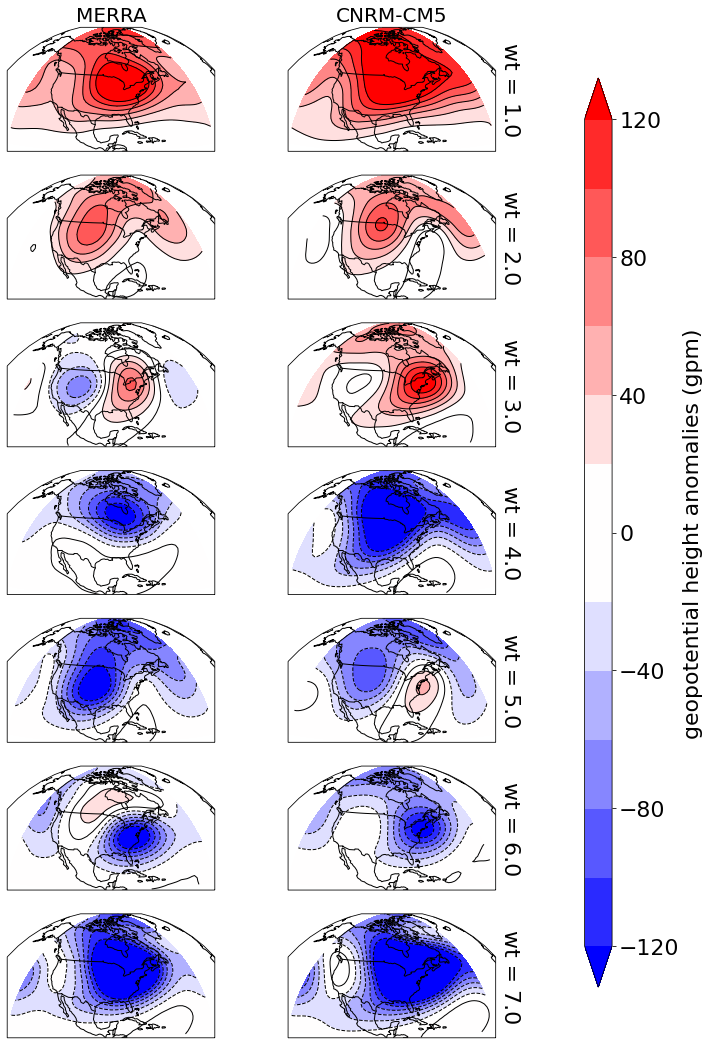

In [8]:
WT=xr.concat([WTrea, WTmod], pd.Index(['MERRA', model], name='dataset'))
plt.rcParams.update({'figure.facecolor' : 'white'})
plt.rcParams.update({'font.size': 22})
countlev=20

n=40
x = 0.5
lower = plt.cm.bwr(np.linspace(0, x, n))
white = plt.cm.bwr(np.ones(90-2*n)*x)
upper = plt.cm.bwr(np.linspace(1-x, 1, n))
colors = np.vstack((lower, white, upper))
tmap = mcolors.LinearSegmentedColormap.from_list('map_white', colors)

p = WT.WT.plot.contourf(
    x='X', y='Y', row='wt', col='dataset',
    transform=ccrs.PlateCarree(),
    subplot_kws={
        'projection': ccrs.Orthographic(-90, 10)
        #ccrs.PlateCarree()
    },
    figsize=(13, 15),
    #vmin=-120, vmax=120,
    levels = np.arange(-120, 130, countlev),
    cmap=tmap,
    extend='both', 
    #norm=norm,
    cbar_kwargs=dict(label='geopotential height anomalies (gpm)',pad=0.1, aspect=30, shrink=0.9) #, orientation='horizontal', ticks=[0, 10, 20 ,30])
)
j = -1
for i, ax in enumerate(p.axes.flat):
    if i<=(len(WT.dataset)-1):  #Indicate models only on the top columns
        ax.set_title(WT.dataset[i].values, fontsize=20)
    #Add black contour lines
    if i % len(WT.dataset) == 0:
        j += 1
    ax.contour(WT.WT['X'], WT.WT['Y'], WT.WT[i-len(WT.dataset)*j][j], linewidths=1, colors='k',levels = np.arange(-120, 130, countlev),transform=ccrs.PlateCarree())

xmin,xmax = WTmod.WT['X'].min(), WTmod.WT['X'].max()
ymin,ymax = WTmod.WT['Y'].min(), WTmod.WT['Y'].max()
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    #ax.set_extent([xmin, xmax, ymin, ymax])

plt.show()

# Procrustes Analysis

In [9]:
print("Disparity (0 means perfect match) for:")
for iwt in range(len(WTrea['wt'])):
    mtx1, mtx2, disparity,R,s = procrustes2(WTrea.WT[iwt], WTmod.WT[iwt])
    print("WT "+str(int(iwt+1))+ ":" +str(round(disparity,2)))

Disparity (0 means perfect match) for:
WT 1:0.06
WT 2:0.04
WT 3:0.34
WT 4:0.12
WT 5:0.1
WT 6:0.59
WT 7:0.08


In [10]:
WTmodT=xr.full_like(WTmod,0)
Scale=xr.full_like(WTmod,0)
Rotation=xr.full_like(WTmod,0)
Translation=xr.full_like(WTmod,0)
print("Disparity (0 means perfect match) for:")
for iwt in range(len(WTrea['wt'])):
    d,z,t = procrustes2d(WTrea.WT[iwt], WTmod.WT[iwt],scaling=True, reflection='best')
    WTmodT.WT[iwt]=z 
    Scale.WT[iwt]=WTmodT.WT[iwt].dot(t['scale'])
    Rotation.WT[iwt]=z @ t['rotation']
    Translation.WT[iwt]=z+t['translation']
    print("WT "+str(int(iwt+1))+ ":" +str(round(d,2)))

Disparity (0 means perfect match) for:
WT 1:0.06
WT 2:0.04
WT 3:0.34
WT 4:0.12
WT 5:0.1
WT 6:0.59
WT 7:0.08


In [11]:
np.round(t['scale'],2).values

array(0.81)

In [12]:
WTf=xr.concat([WTrea, WTmod, WTmodT], pd.Index(['MERRA', model, model+' (Procrustes)'], name='dataset'))
Procrustes=xr.concat([WTmod, Scale, Rotation, Translation], pd.Index([model, 'Scaled', 'Rotated', 'Translated'], name='dataset'))

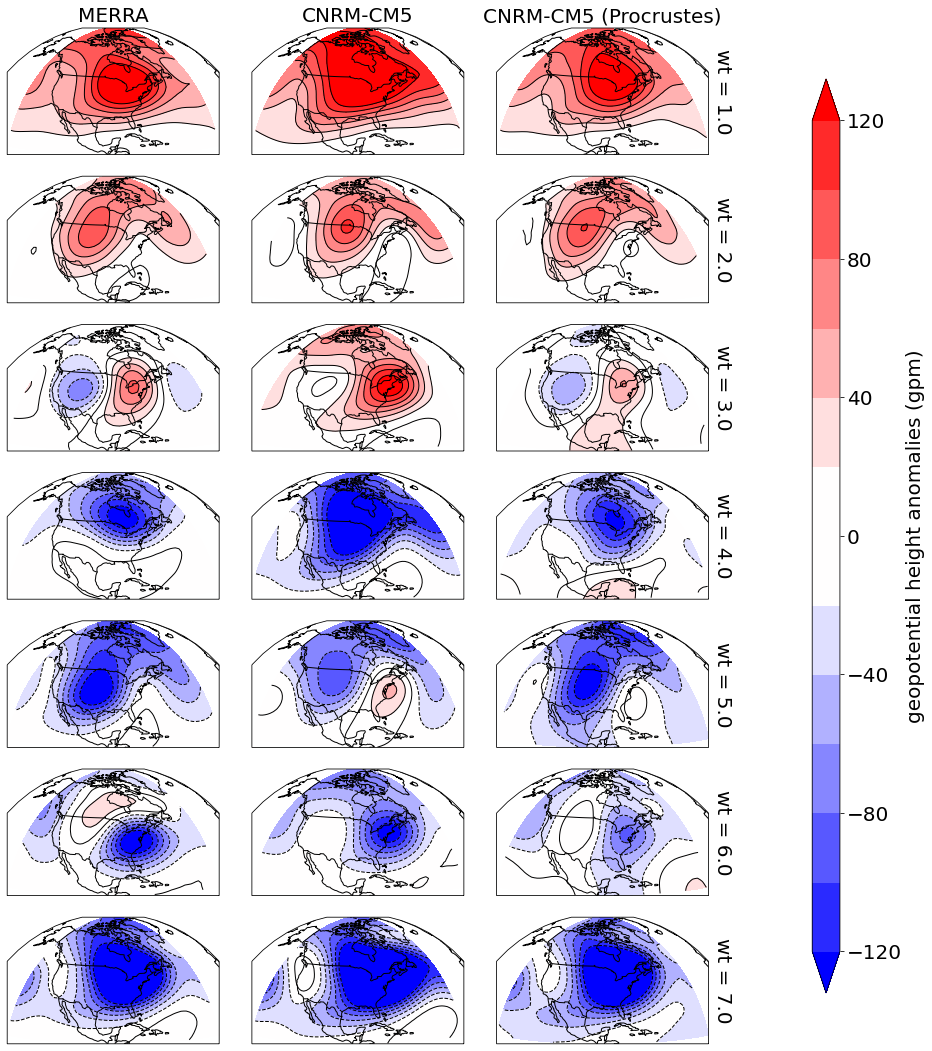

In [13]:
plt.rcParams.update({'font.size': 20})
countlev=20

p = WTf.WT.plot.contourf(
    x='X', y='Y', row='wt', col='dataset',
    transform=ccrs.PlateCarree(),aspect=WTf.dims['X'] / WTf.dims['Y'],
    subplot_kws={
        'projection': ccrs.Orthographic(-90, 10)  #ccrs.Orthographic(-80, 35)
        #ccrs.PlateCarree()
    },
    figsize=(15, 15),
    levels = np.arange(-120, 130, countlev),
    cmap=tmap,
    extend='both',
    cbar_kwargs=dict(label='geopotential height anomalies (gpm)',pad=0.1, aspect=30, shrink=0.9) #, orientation='horizontal', ticks=[0, 10, 20 ,30])
)
j = -1
for i, ax in enumerate(p.axes.flat):
    if i<=(len(WTf.dataset)-1):  #Indicate models only on the top columns
        ax.set_title(WTf.dataset[i].values, fontsize=20)
    #Add black contour lines
    if i % len(WTf.dataset) == 0:
        j += 1
    ax.contour(WTf.WT['X'], WTf.WT['Y'], WTf.WT[i-len(WTf.dataset)*j][j], linewidths=1, colors='k',levels = np.arange(-120, 130, countlev),transform=ccrs.PlateCarree())

xmin,xmax = WTf.WT['X'].min(), WTf.WT['X'].max()
ymin,ymax = WTf.WT['Y'].min(), WTf.WT['Y'].max()
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    #ax.set_extent([xmin, xmax, ymin, ymax])

plt.savefig('ProcrustesCorrection_'+ model +'.pdf')
plt.show()

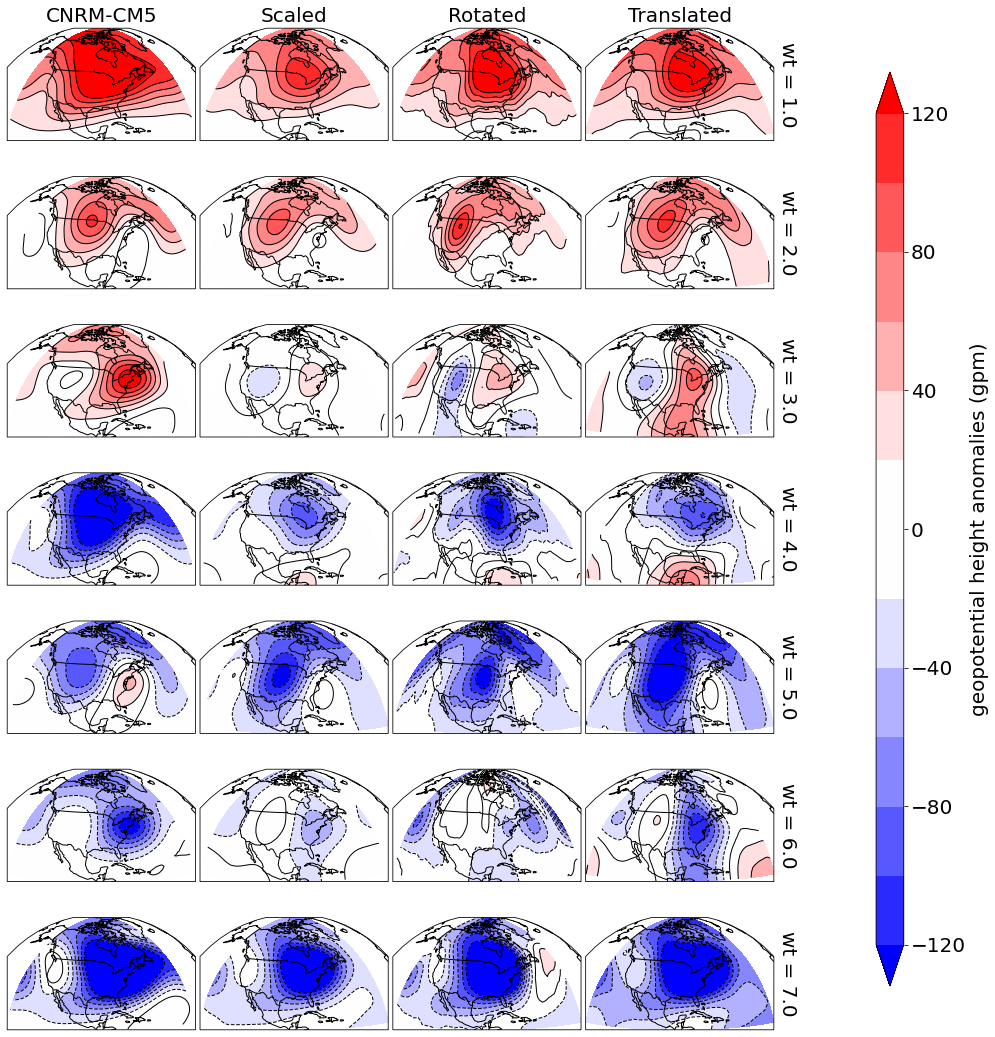

In [14]:
plt.rcParams.update({'font.size': 20})
countlev=20

p = Procrustes.WT.plot.contourf(
    x='X', y='Y', row='wt', col='dataset',
    transform=ccrs.PlateCarree(),aspect=Procrustes.dims['X'] / Procrustes.dims['Y'],
    subplot_kws={
        'projection': ccrs.Orthographic(-90, 10)  #ccrs.Orthographic(-80, 35)
        #ccrs.PlateCarree()
    },
    figsize=(15, 15),
    levels = np.arange(-120, 130, countlev),
    cmap=tmap,
    extend='both',
    cbar_kwargs=dict(label='geopotential height anomalies (gpm)',pad=0.1, aspect=30, shrink=0.9) #, orientation='horizontal', ticks=[0, 10, 20 ,30])
)
j = -1
for i, ax in enumerate(p.axes.flat):
    if i<=(len(Procrustes.dataset)-1):  #Indicate models only on the top columns
        ax.set_title(Procrustes.dataset[i].values, fontsize=20)
    #Add black contour lines
    if i % len(Procrustes.dataset) == 0:
        j += 1
    ax.contour(Procrustes.WT['X'], Procrustes.WT['Y'], Procrustes.WT[i-len(Procrustes.dataset)*j][j], linewidths=1, colors='k',levels = np.arange(-120, 130, countlev),transform=ccrs.PlateCarree())

xmin,xmax = Procrustes.WT['X'].min(), Procrustes.WT['X'].max()
ymin,ymax = Procrustes.WT['Y'].min(), Procrustes.WT['Y'].max()
for ax in p.axes.flat:
    ax.coastlines()
    ax.add_feature(feature.BORDERS)
    #ax.set_extent([xmin, xmax, ymin, ymax])

plt.savefig('ProcrustesAnalysis_'+ model +'.pdf')
plt.show()